In [1]:
import numpy as np
import pandas as pd
import random
import time

from tqdm import tqdm
import seaborn as sb

from streamz import Stream

In [2]:
from panoptes.utils.database import PanDB
from panoptes.utils.serializers import from_json, to_json
from panoptes.utils.serial.device import SerialDevice
from panoptes.utils.time import current_time

In [3]:
serial_port = 'loop://'
serial_name = 'Loop Device'

We create a simple function that will create a random device entry.  You can use the `num_devices` to specify a random device reading:

In [4]:
def random_entry(num_devices=4):
    devices = [f'sensor{i:02d}' for i in range(num_devices)]
    return to_json(dict(time=current_time(), label=random.choice(devices), reading=np.random.normal()))

In [5]:
# Show sample entry.
print(f'{random_entry()!r}')

'{"time": "2022-06-30T19:19:33.550", "label": "sensor00", "reading": 1.9547457118022966}'


Now write a simple function that will write `num_entries` of `random_entry()` to the given device.

In [6]:
def write_random_entries(dev_entry, num_entries=50, num_devices=4, delay=0.05):
    for _ in tqdm(range(num_entries)):
        dev_entry.write(random_entry(num_devices=num_devices))
        time.sleep(delay)

### Default SerialDevice

This has a basic reader has a stream that will append to a `deque(maxlen=reader_queue_size)` called `readings`.

In [7]:
# Default just appends to deque.
dev0 = SerialDevice(port=serial_port, name=serial_name, reader_queue_size=100)

2022-06-30 09:19:33.565 | DEBUG    | panoptes.utils.serial.device:__init__:182 - SerialDevice for Loop Device created. Connected=True
2022-06-30 09:19:33.565 | DEBUG    | panoptes.utils.serial.device:__init__:187 - Applying settings to serial class: {'baudrate': 9600, 'timeout': 1.0, 'write_timeout': 1.0, 'bytesize': 8, 'parity': 'N', 'stopbits': 1, 'xonxoff': False, 'rtscts': False, 'dsrdtr': False}


In [8]:
# Starts empty.
dev0.readings

deque([])

In [9]:
# Write some random entries.
write_random_entries(dev0, num_entries=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.04it/s]


In [10]:
# We filled up our deque
len(dev0.readings)

100

In [11]:
# Show first entry, which is just an output from random_entry()
first_entry = dev0.readings[0]
print(f'{first_entry!r} is a {type(first_entry)}')

'{"time": "2022-06-30T19:19:33.584", "label": "sensor01", "reading": 1.1269949511090236}' is a <class 'str'>


In [12]:
# We can convert these readings to json and make into a dataframe.
dev_df0 = pd.DataFrame([from_json(d) for d in list(dev0.readings)])

<AxesSubplot:xlabel='time', ylabel='reading'>

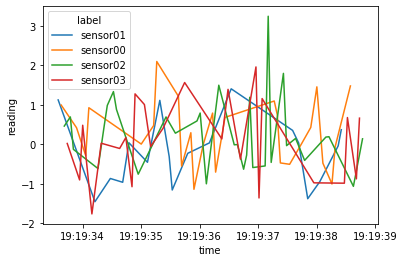

In [13]:
sb.lineplot(data=dev_df0, x='time', y='reading', hue='label')

### SerialDevice with custom stream

Here we will make a custom stream that simply maps the entries into a small function we create. Our stream should not end in a `sink`, which is handled by the `SerialDevice` (and appends to the `readings` as seen above).

The custom stream function function will take one parameter, which is the string that the device reads.  Here we convert to json, add a timestamp, and write it to our (in-memory) database.

In [14]:
db = PanDB(db_type='memory')
db.clear_current('serial')  # Just to make sure.

2022-06-30 09:19:39.207 | INFO     | panoptes.utils.database.base:__init__:55 - Creating PanDB None


In [15]:
# Add a custom stream that converts json, adds timestamp, and writes to db.
def record_json_data(data):
    data = from_json(data)        
    data['time'] = current_time(datetime=True)
    db.insert_current('serial', data)
    return data

dev1 = SerialDevice(port=serial_port, name=serial_name, reader_callback=record_json_data)

2022-06-30 09:19:39.218 | DEBUG    | panoptes.utils.serial.device:__init__:182 - SerialDevice for Loop Device created. Connected=True
2022-06-30 09:19:39.219 | DEBUG    | panoptes.utils.serial.device:__init__:187 - Applying settings to serial class: {'baudrate': 9600, 'timeout': 1.0, 'write_timeout': 1.0, 'bytesize': 8, 'parity': 'N', 'stopbits': 1, 'xonxoff': False, 'rtscts': False, 'dsrdtr': False}


In [16]:
dev1.readings

deque([])

In [17]:
# Write some random entries.
write_random_entries(dev1, num_entries=1001, delay=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:02<00:00, 371.80it/s]


In [18]:
# The stream still sinks into the queue, here with the default size of 50.
len(dev1.readings)

50

In [19]:
# But it also write to the database.
db.get_current('serial')

{'_id': '94872940-8b83-44c5-afe9-5fefca180acc',
 'data': {'time': datetime.datetime(2022, 6, 30, 19, 19, 42, 50000),
  'label': 'sensor02',
  'reading': 0.5257778729543175},
 'type': 'serial',
 'date': datetime.datetime(2022, 6, 30, 19, 19, 42, 51000)}

In [20]:
# All of the entries too!
len(db.collections['serial'])

1001

In [21]:
# The database has nested dicts by _id values.
dev1_readings = list(db.collections['serial'].values())
dev1_readings[0]

'{"_id": "cad6291d-1f5b-4fb8-92fb-e11a7851a22e", "data": {"time": "2022-06-30T19:19:39.325", "label": "sensor01", "reading": 0.6446314152317812}, "type": "serial", "date": "2022-06-30T19:19:39.328"}'

In [22]:
# Get the `data` key from the readings
dev_df1 = pd.DataFrame([from_json(d)['data'] for d in dev1_readings])
dev_df1 = dev_df1.set_index('time').sort_index()

<AxesSubplot:xlabel='time', ylabel='reading'>

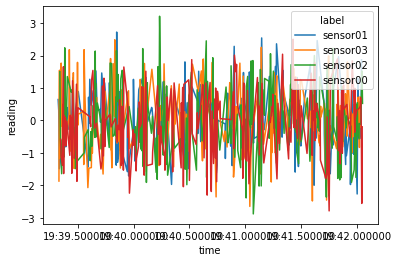

In [23]:
sb.lineplot(data=dev_df1, x='time', y='reading', hue='label')